# La Palma Lava Mapping Toolkit

**A toolkit for the semi-automatic mapping of lava, based on the 2021 La Palma *Cumbre Vieja* eruption, using Sentinel-1 data**

Creator: [Luke McQuade](https://github.com/lukesdm) @ [Z_GIS](https://www.plus.ac.at/geoinformatik/?lang=en), as part of the [Copernicus Master in Digtial Earth](https://www.master-cde.eu/) programme.

## Introduction

On Sunday 19th September 2021, the Canarian island of La Palma experienced a stratovolcanic eruption on the Cumbre Veija ridge. The eruption lasted until Tuesday 13th December - almost 3 months. Due to early detection and action of the local authorities, there was no direct loss of human life. However, there was significant damage to infrastructure, buildings and land ([Carracedo, Troll et al, 2022](https://onlinelibrary.wiley.com/doi/10.1111/gto.12388)).

Eruptions are often accompanied by large amounts of smoke and particulates, which can reduce the effectiveness of optical imaging satellites for monitoring. The [Copernicus Sentinel-1](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-1) synthetic aperture radar (SAR) mission, whose data is freely available, has the ability to penetrate clouds, darkness and smoke plumes and so can be an effective tool in these situations. This data can be notoriously difficult to interpret, however.

An approach based on the tools and principles of [GEOBIA](https://gisgeography.com/obia-object-based-image-analysis-geobia/) is presented here for the semi-automatic mapping/classification of active lava flows - initially for the La Palma *Cumbre Vieja* event, with transferability still to be investigated.

This notebook will demonstrate the process, which involves segmentation, feature engineering and knowledge-based classification.

### About the notebook

There are some interactive sections, indicated by 📝, where user input is required. Some reasonable defaults have been chosen though, if you just want to run all the cells in one go.

This is experimental, unoptimised code, and some cells will take some time to run. ⏱ indicates such cells.

The notebook has been designed to allow you to re-try the workflow with different options. Change the desired parameter value, and run the subsequent cells to see the new results.

## Setup

### Import dependencies

In [189]:
import matplotlib.pyplot as plt
from ipywidgets import interact

import lplm_geoprocessing as lpgeo
import lplm_io as lpio
import lplm_presentation as lpp
import lplm_utils as lpu
import lplm_eda as lpe

In [190]:
# Run this to reload custom modules after making changes 
import importlib
importlib.reload(lpgeo)
importlib.reload(lpio)
importlib.reload(lpp)
importlib.reload(lpu)
importlib.reload(lpe)

<module 'lplm_eda' from '/home/jovyan/lplm/lplm_eda.py'>

### Load a map

In [205]:
# Map inputs needs to be passed in as EPSG:4326 even though map CRS is EPSG:3857. 
map_center = ( (28.58 + 28.65) / 2, (-17.97 + -17.84) / 2)
 
from sidecar import Sidecar
from ipyleaflet import Map, LayersControl, projections
lp_map = Map(
    center=map_center,
    zoom=13,
    crs=projections.EPSG3857,
    scroll_wheel_zoom=True)
lp_map.add_control(LayersControl())
sc = Sidecar()
with sc:
    display(lp_map)

## 📝 Explore the imagery and choose a date

The dataset is a series of Sentinel-1 ground-range-detected (GRD) images captured on the dates before, during and after the eruption, with the following characteristics (see [*About Sentinel-1 GRD Data*](https://docs.sentinel-hub.com/api/latest/data/sentinel-1-grd/) for an explanation of these):
* Acquisition mode: Interferometric wide swath (IW)  
* Signal type: Backscatter intensity (linear) - $\gamma_{0}$ (radiometrically terrain corrected)   
* Polarisation: VV  
* Orbit: Ascending  
* DEM correction: 30m Mapzen  

Take a look at the images - if you view them in series, you should be able roughly make out the progression of the lava flow.

Choose an image date to perform the analysis on.

Note that '2021-09-10' and '2021-09-16' are pre-event images.

In [206]:
# Load imagery
xds_grd = lpio.load_series("data")

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["figure.dpi"] = 100

selected_date = lpu.to_date('2021-11-15')

def view_scene(date=selected_date):
    # Use this date for the rest of the notebook
    global selected_date 
    
    layer_sar = lpp.make_sar_layer(xds_grd, date)
    lpp.replace_layer(lp_map, layer_sar, lpp.sar_layer_name(selected_date))
    selected_date = date
    # TODO: add vent layer
    
interact(view_scene, date=lpp.get_date_labels(xds_grd))

interactive(children=(Dropdown(description='date', index=10, options=(('2021-09-10', numpy.datetime64('2021-09…

<function __main__.view_scene(date=Timestamp('2021-11-15 00:00:00'))>

## ⏱ Perform segmentation

[Radar speckle](https://en.wikipedia.org/wiki/Speckle_(interference)), geometric distortions, and other properties make analysis at the single-pixel level error-prone. There are various filtering methods available that attempt to counter this. However, there is always a risk of losing spatial or textural information this way.

Try zooming in. As you can see, active lava flow can be difficult or impossible to differentiate from its surroundings. It needs to be examined with more context. [SLIC0](https://www.epfl.ch/labs/ivrl/research/slic-superpixels/) segmentation allows for this. It can be thought of as a sort of 'smart chessboard' segmentation, as it divides the image into similar sized segments, which roughly follow object borders. 

In [207]:
lpgeo.apply_segmentation(xds_grd,
                         selected_date,
                         # These values produce segments around 16-18 pixels or 160-180m across for this imagery:
                         n_segments = 5000,
                         compactness = 0.1)

gdf = lpgeo.vectorize_segments(xds_grd)

# Display results
from ipyleaflet import GeoData
# Have to convert to EPSG:4326 first, despite map CRS.
layer_seg = GeoData(
    geo_dataframe = gdf.to_crs("EPSG:4326"),
    style = { "fillOpacity": 0.0, "weight": 1.0 },
    name = "Segments")
lpp.replace_layer(lp_map, layer_seg)

## Calculate segment pixel statistics

The first step in the analysis is to determine the statistics of the segments' pixel values: the mean, which is heavily influenced by surface type, and the standard deviation, which is a rough indicator of texture.

In [208]:
xds_segstats = lpgeo.segment_stats(xds_grd)

lpgeo.enrich_stats(gdf, xds_segstats, selected_date)

# TODO: show a layer here

## 📝 Select a reference sample

Hopefully, through visual inspection of a series of images, you will be able to identify an area that is clearly part of the active lava flow. Drag the sampling rectangle to choose a reference sample. 

In [209]:
# Choose sample area
from ipyleaflet import Polygon

layer_sample_poly = Polygon(
    name="Reference sample - selection box",
    locations=[
        (28.614, -17.903),
        (28.614, -17.89),
        (28.624, -17.89),
        (28.624, -17.903)
    ], transform=True)

lpp.replace_layer(lp_map, layer_sample_poly)

# Note: there seems to be a bug in ipyleaflet that leaves the handles after removing or hiding the layer.

The statistics of the underlying segments will guide the classification. The cell below calculates these. You may wish to adjust your sample selection and try again.

In [210]:
# Find matching segments
from shapely import geometry

# Initial and manually-adjusted polygon have different point data layouts. So have to handle both.
try:
    shapely_sample_4326 = geometry.Polygon([(pdict["lng"], pdict["lat"]) for pdict in layer_sample_poly.locations[0]])
except:
    shapely_sample_4326 = geometry.Polygon([(lon, lat) for (lat, lon) in layer_sample_poly.locations])
# gds_sample_3857 = geopandas.GeoSeries(shapely_sample_4326, crs="EPSG:4326").to_crs("EPSG:3857")
# For some reason, doing the intersection calc in EPSG:3857 doesn't always work - could be the point ordering in the polygon?
# So, as a workaround just do it in EPSG:4326.
gdf_4326 = gdf.to_crs("EPSG:4326")
gdf_sample_4326 = gdf_4326.loc[gdf_4326.intersects(shapely_sample_4326)]

# Display the result
from ipyleaflet import GeoData
layer_sample = GeoData(geo_dataframe=gdf_sample_4326, name="Reference sample - segments")
lpp.replace_layer(lp_map, layer_sample)

### Inspect distributions

The cell below will pick a few segments from the sample (sub-sample), and show the distributions of their $\gamma_{0}\$ pixel values. Running it again will choose a different set of segments.

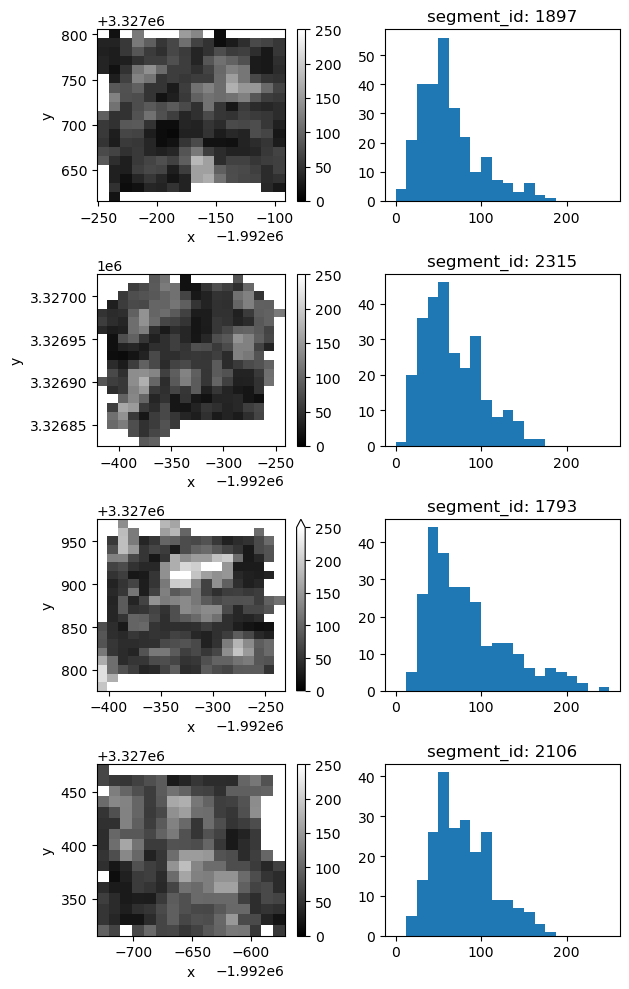

In [211]:
sample_segids = gdf_sample_4326["segment_id"].sample(4).values
lpe.plot_segment_histos(xds_grd, sample_segids, selected_date)

Now, run the cell below and inspect the distributions of segment means and standard deviations over the entire sample.

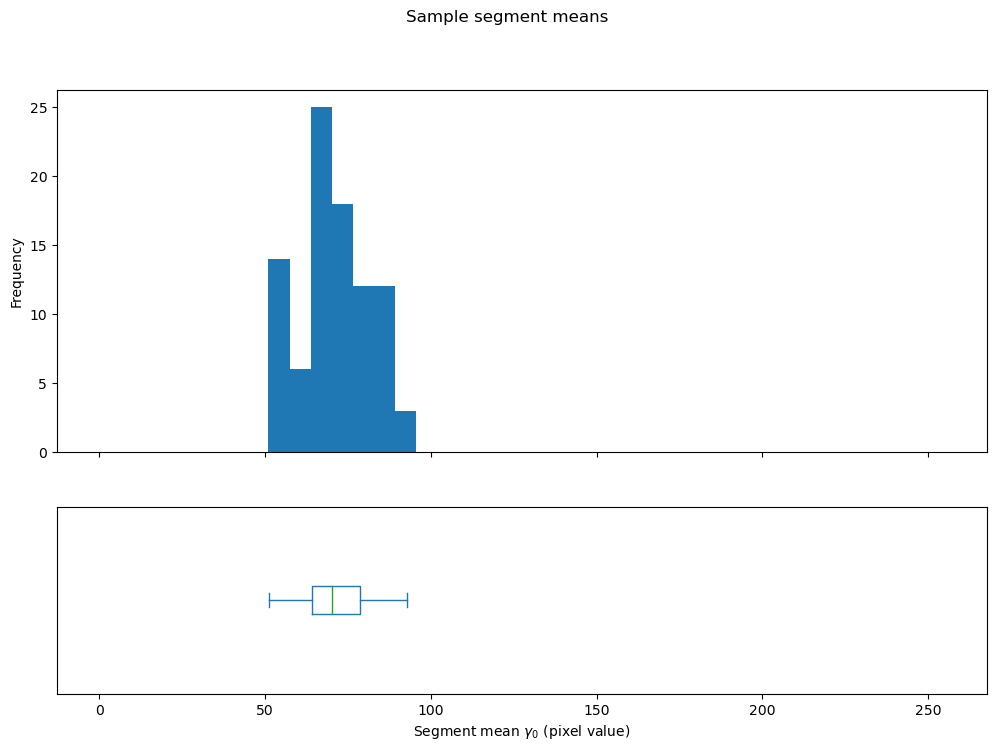

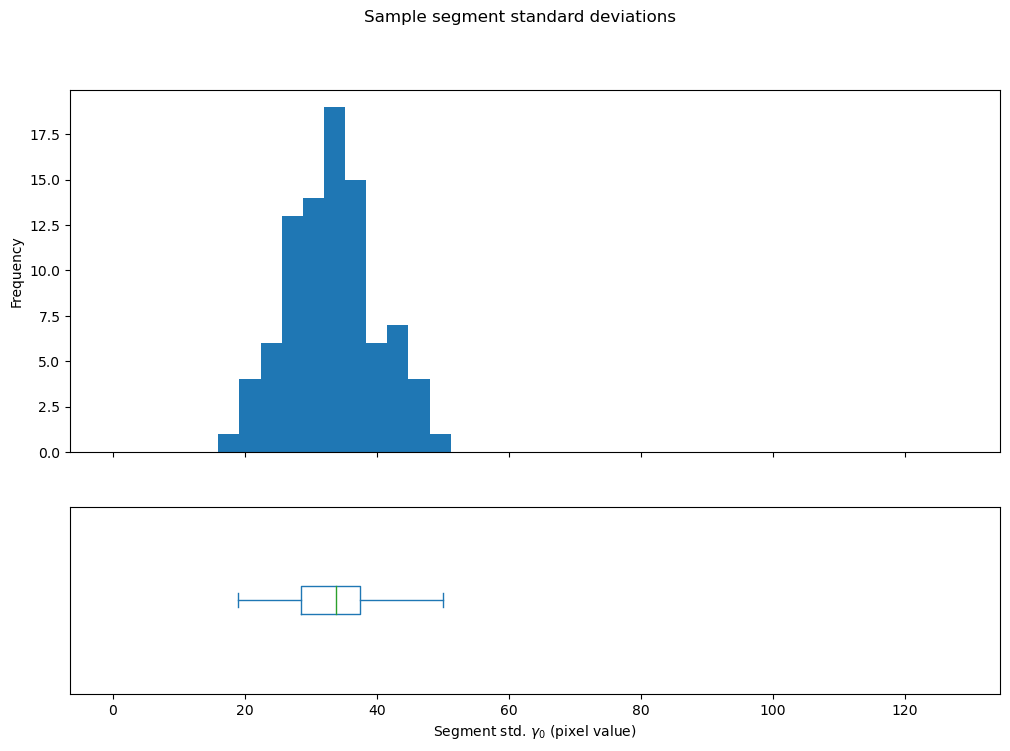

In [212]:
lpe.plot_segment_stats_dists(gdf_sample_4326)

You may wish to repeat the past few steps for areas *outside* the lava flow for comparison. Remember to make your final sample is within the flow though, as it is used in the subsequent calculations.

## Lava-likeness metrics

The similarities of the segment mean and standard deviation to those of the reference sample can be used as a basis for determining lava-likeness. The *local lava-likeness* is calculated by comparing the features of a single segment against the sample, without additional context. See `local_lava_likeness` in `lplm_geoprocessing.py` for the implementation of this.

### ⏱ Calculate local lava-likeness

In [213]:
lpgeo.enrich_lava_likeness(gdf, gdf_sample_4326.to_crs("3857"))

layer_enriched = lpp.make_feature_layer(gdf, "local_lava_likeness")

lpp.replace_layer(lp_map, layer_enriched)

### Neighbourhood lava-likeness

Inspecting the produced *local lava-likeness* layer on the map, you will see some centralized clustering, but there are patches of segments with with mid-high values all over the map. On its own, this is not enough to classify active lava.

We can combine this with a knowledge-based rule: The active flow will probably be a connected region, i.e., lava is more likely be next to other lava.

This can be modelled with a dynamic approach - determining a segment's overall lava-likeness by visiting its neighbours, and inspecting *their* lava-likeness. See `neighbourhood_lava_likeness` in `lplm_geoprocessing.py` for the implementation of this.

## Estimate the active flow region

Again, the neighbourhood-based lava-likeness would result in lava-like regions outside the active lava flow, due to the similarity of the surface types. But, seeding the lava classifier with a known-point inside the flow can be used to restrict this to a single region.

### 📝 Choose a starting point

Choose somewhere clearly in the active lava region.

In [214]:
from ipyleaflet import Marker
marker = Marker(location=map_center, draggable=True, name="Start")
lpp.replace_layer(lp_map, marker)

### ⏱ Run the algorithm

Now, lava-likeness above a pre-determined threshold will be classified as lava, and a continuous region is determined from this.

In [215]:
# Find the matching segment for the start point
from pyproj import Transformer
t = Transformer.from_crs("epsg:4326", "epsg:3857")
start_x, start_y = t.transform(marker.location[0], marker.location[1])
start_segment_id = lpgeo.get_segment_id(gdf, start_x, start_y)

# Run the neighbourhood-aware classifier
# TODO: Fix warnings for this
import warnings
warnings.filterwarnings('ignore')
lpgeo.lava_likeness_overall(gdf, start_segment_id)

# Merge the classified segments into a single region
gdf_lava_est = lpgeo.extract_lava_region(gdf, start_segment_id)

# Show the results
layer_neigh_ll = lpp.make_feature_layer(gdf, "neighbourhood_lava_likeness")
layer_lava = GeoData(
    geo_dataframe = gdf_lava_est.to_crs("EPSG:4326"),
    style = { "fillOpacity": 1.0, "weight": 1.0, "fillColor": "orange" },
    name = "Estimated active lava flow")
lpp.replace_layer(lp_map, layer_neigh_ll)
lpp.replace_layer(lp_map, layer_lava)

## Compare with reference maps

The Copernicus Emergency Rapid Mapping service provided maps through the course of the eruption. These were created with the aid of high resolution sources of various types, such as [COSMO-SkyMed](https://earth.esa.int/eogateway/missions/cosmo-skymed), a high resolution X-band SAR mission. See the [event page](https://emergency.copernicus.eu/mapping/ems/volcano-eruption-la-palma-spain) for further details. With a few of these as a reference, let's compare our results. 

In [216]:
import geopandas
ems_maps = {
    "2021-11-15": geopandas.read_file("ems-reference/EMSR546_AOI01_GRA_MONIT52_observedEventA_r1_v1.shp"),
    "2021-11-21": geopandas.read_file("ems-reference/EMSR546_AOI01_GRA_MONIT53_observedEventA_r1_v1.shp"),
    "2021-12-18": geopandas.read_file("ems-reference/EMSR546_AOI01_GRA_MONIT63_observedEventA_r1_v1.shp"),
}

def ems_layer_name(key):
    return f"EMS Rapid Mapping @ {key}"

def make_ems_layer(key):
    layer = GeoData(
        geo_dataframe = ems_maps[key].to_crs("EPSG:4326"),
        style = { "fillOpacity": 0.0, "weight": 1.0, "color": "red" },
        name = ems_layer_name(key))
    return layer

layers_ems = {}

for key in ems_maps.keys():
    layers_ems[key] = make_ems_layer(key)

selected_ems = None
    
def show_ems_layer(ems_map_date):
    global selected_ems
    lpp.replace_layer(lp_map, layers_ems[ems_map_date], ems_layer_name(selected_ems))
    selected_ems = ems_map_date
    return None
    
interact(show_ems_layer, ems_map_date=ems_maps.keys())

interactive(children=(Dropdown(description='ems_map_date', options=('2021-11-15', '2021-11-21', '2021-12-18'),…

<function __main__.show_ems_layer(ems_map_date)>

## Discussion and next steps

As you can see, the results are mixed, and vary by date. For instance, there is often significant over-spill to the north east. Around the vents tend to be under-classified, possibly due to terrain shadowing caused by the incident angle of the SAR sensor.

The [lava platform](https://www.esa.int/ESA_Multimedia/Images/2021/10/La_Palma_lava_flows_into_the_sea) is also often under-classified, again likely due to shadowing caused by the steep 90m drop from land to ocean.

The approach presented here should be considered a first step, and there are many potential improvements and avenues to explore, such as:
* Incorporate digital elevation model (DEM) data, based on the knowledge that lava (mostly) flows downhill.  
* Improve the effectiveness of the segmentation by pre-processing with, e.g., Sobel edge detection.
* Analyse the segment statistics of other land cover types for elimination purposes.
* Augment with available optical imagery.
* Experiment further with algorithm parameters.



## References

...